In [1]:
import json
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Extracting

In [2]:
def get_daily_adjusted_ts(ticket, outputsize='compact', start_date='2019-01-01', end_date='2021-06-01'):
    api_key = 'GXFDHG1HGXVBY5ON' #os.getenv('ALPHA_VANTAGE_API_KEY')
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticket}&outputsize={outputsize}&apikey={api_key}'
    response = requests.get(url)
    if response.ok:
        json_body = json.loads(response.text)
        metadata = json_body['Meta Data']
        data = pd.DataFrame(json_body['Time Series (Daily)']).transpose()
        data = data[end_date:start_date].sort_index()
        data.columns = [i[2:].lstrip() for i in data.columns]
        data = data.astype({
            'open': 'float', 
            'high': 'float', 
            'low': 'float', 
            'close': 'float', 
            'adjusted close': 'float', 
            'dividend amount': 'float', 
            'split coefficient': 'float', 
            'volume': 'int32'
        })
        
        data = data.reset_index()
        data['index'] = pd.to_datetime(data['index'])
        data = data.set_index('index')

        return data, metadata
    return url
    

#### Extract historical daily closing stock prices of AT&T and Verizon for the period of 01/01/2019 to 06/01/2021 via Alpha Vantage API and check the data using the head() function to see if you properly imported it.

In [3]:
att, att_metadata = get_daily_adjusted_ts('T', 'full')
vz, vz_metadata = get_daily_adjusted_ts('VZ', 'full')

In [4]:
att.head()

,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
index,,,,,,,,
2019-01-02,28.50,29.59,28.30,29.54,16.875687,39293953,0.0,1.0
2019-01-03,29.52,29.81,29.21,29.58,16.898538,37603571,0.0,1.0
2019-01-04,29.96,30.38,29.89,30.34,17.332713,42072388,0.0,1.0
2019-01-07,30.73,31.27,30.42,30.89,17.646918,41070898,0.0,1.0
2019-01-08,31.31,31.38,31.03,31.28,17.869719,43567261,0.0,1.0


In [5]:
vz.head()

,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
index,,,,,,,,
2019-01-02,56.16,56.16,55.28,56.02,45.945201,13969691,0.0,1.0
2019-01-03,56.30,56.99,56.06,56.22,46.109233,19245411,0.0,1.0
2019-01-04,56.49,56.89,55.95,56.36,46.224055,17035848,0.0,1.0
2019-01-07,56.76,57.26,56.55,56.72,46.519311,16348982,0.0,1.0
2019-01-08,57.27,58.69,57.05,58.38,47.880772,21425008,0.0,1.0


#### Draw a line plot to visually check if there is any obvious trend or seasonality in the data.

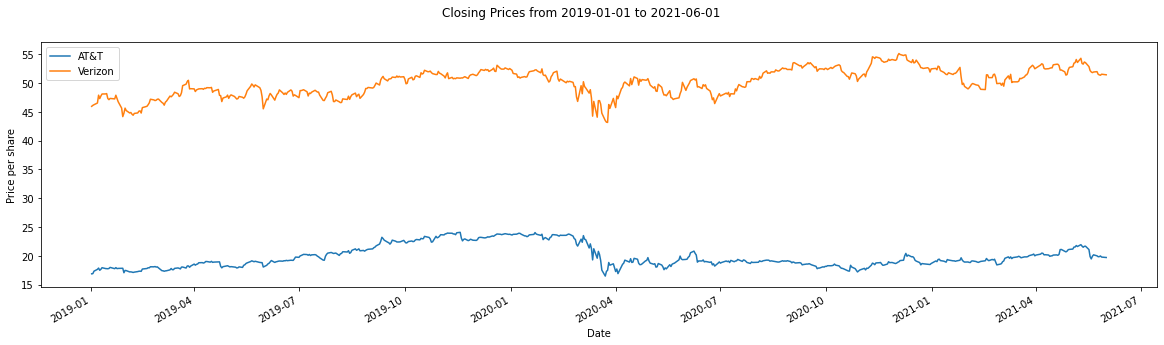

In [6]:
fig, ax = plt.subplots(figsize=(20,5))

fig.suptitle('Closing Prices from 2019-01-01 to 2021-06-01')

ax.plot(att['adjusted close'], label='AT&T')
ax.plot(vz['adjusted close'], label='Verizon')

ax.set_xlabel('Date')
ax.set_ylabel('Price per share')

ax.legend()
fig.autofmt_xdate()
plt.show()

There seems to be a general similarity in the price series for AT&T abd Verizon.
The scale of prices is different as Verizon price range between $44 to $55 in the year under review while AT&T ranges from $16  to around $25.

### Using the seasonal_decompose function, try to detect the time series components. Interpret the result you obtain.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
def plot_decomposition(price_series, decomposition, ticker):
    fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(20, 10))

    fig.suptitle(f'Time series decompositions for {ticker}')

    ax[0].plot(price_series)
    ax[0].set_ylabel('Price')

    ax[1].plot(decompositions.seasonal)
    ax[1].set_ylabel('Seasonality')

    ax[2].plot(decompositions.trend)
    ax[2].set_ylabel('Trend')

    ax[3].plot(decompositions.resid)
    ax[3].set_ylabel('Residuals')

    fig.autofmt_xdate()
    plt.show()

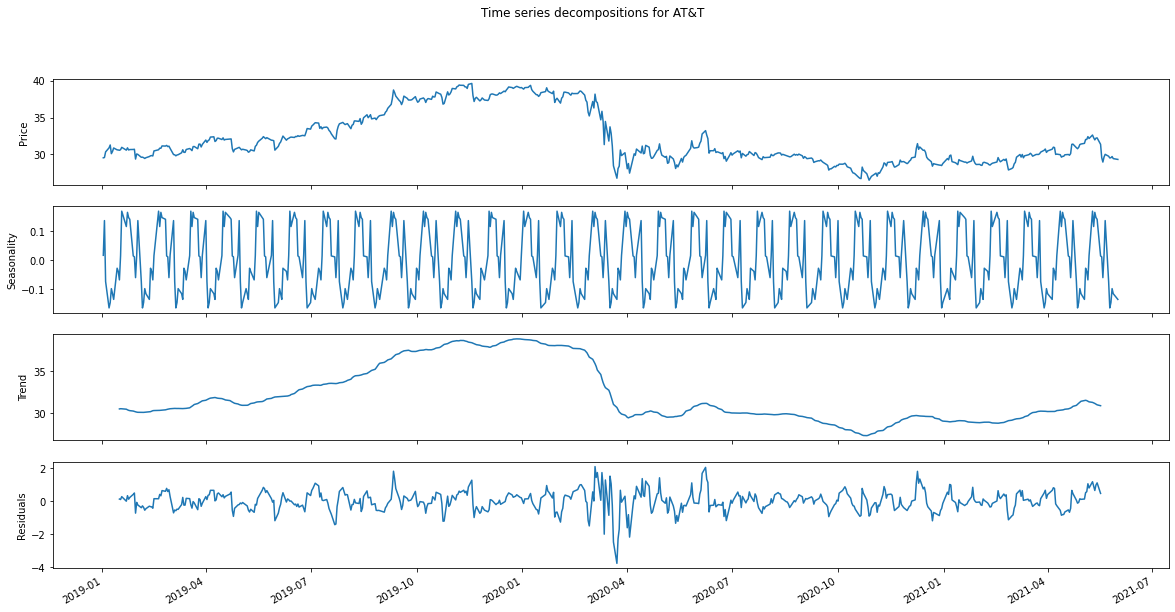

In [27]:
att_decompositions = seasonal_decompose(att['close'], period=20)
plot_decomposition(att['close'], att_decompositions, 'AT&T')

The time series of AT&T closing prices has all three components - trend, seasonality and residual. 
The trend shows a stock price rising from around 30 dollars through to about 40 in the first quarter of 2020 when a crash betweens the price to around 25 dollars.
There appears to be a monthly (20-days) seasonal pattern in the time series.
Residuals appears to be stationary around mean of 0.

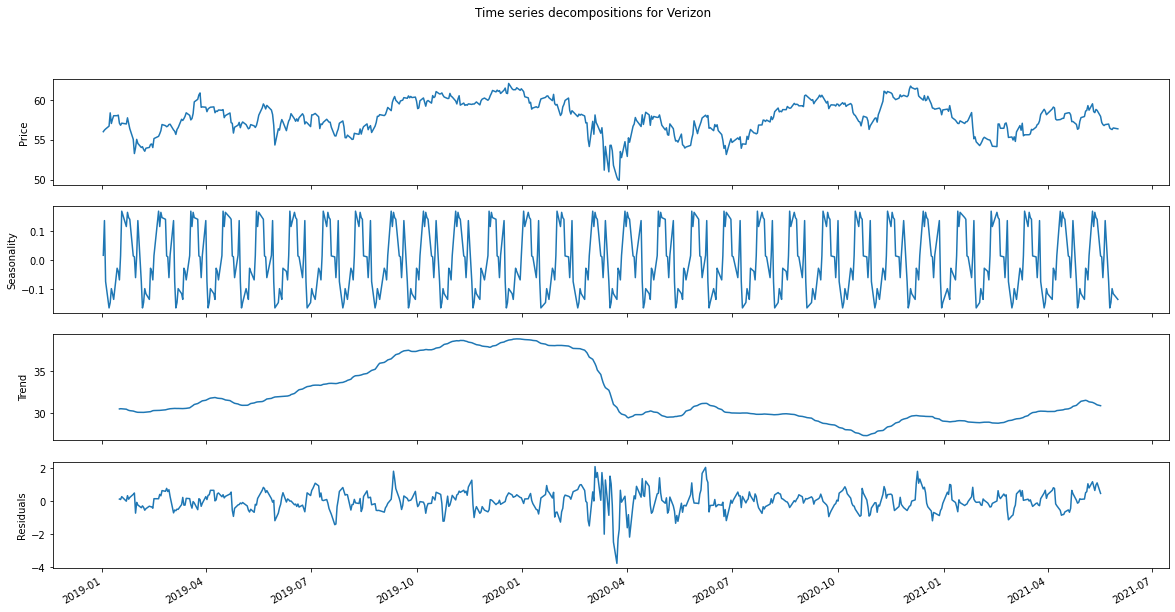

In [29]:
vz_decompositions = seasonal_decompose(vz['close'], period=20)
plot_decomposition(vz['close'], vz_decompositions, 'Verizon')

The Verizon price series decomposition resembles that of AT&T. The time series has all three components - trend, seasonality and residual. 

# Identifying Time Series Components

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### AT&T

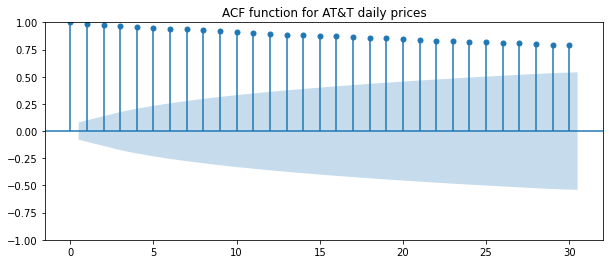

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(att.close, lags=30, title='ACF function for AT&T daily prices', ax=ax);

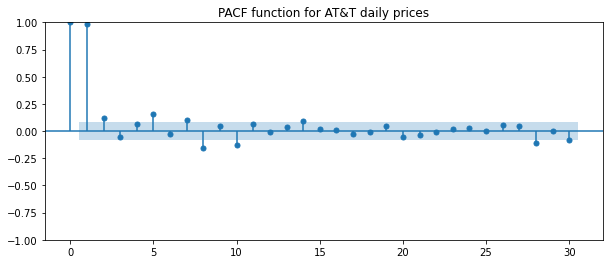

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(att.close, lags=30, method='ywm', title='PACF function for AT&T daily prices', ax=ax);

### Verizon

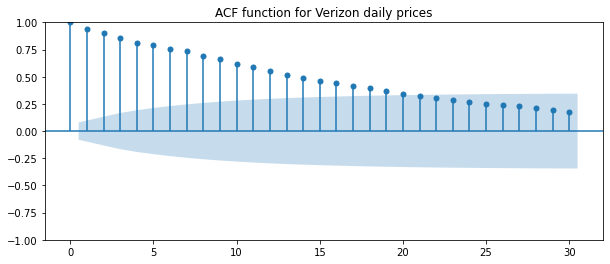

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(vz.close, lags=30, title='ACF function for Verizon daily prices', ax=ax);

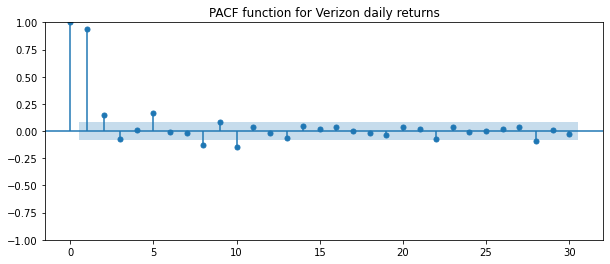

In [48]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(vz.close, lags=30, method='ywm', title='PACF function for Verizon daily returns', ax=ax);

The ACF for Verison shows the presence of a trend that decays slowly though faster than that of AT&T.
The PACF plot shows that is't much correlation between currently price and lagged prices beyond lag 1. Also some spikes are observed at lags 3, 6, 9 and 11, it is not obvious if these are statistically significant.

# Dealing With Non-Stationarity

In [49]:
from statsmodels.tsa.stattools import adfuller

In [50]:
def test_stationarity(ser):
    adf_test = adfuller(ser, maxlag=40)
    return adf_test, adf_test[1] < 0.05

### AT&T

In [53]:
test_stationarity(att.close)

((-1.6014546664388996,
  0.4828627017814223,
  9,
  598,
  {'1%': -3.4413325959192393,
   '5%': -2.86638530474078,
   '10%': -2.569350430308386},
  895.4342250683669),
 False)

ATT prices are not stationary, so differencing is needed.

In [54]:
att_close_diff = np.diff(att.close, n=1)

In [55]:
test_stationarity(att_close_diff)

((-7.580639300672086,
  2.687729425970039e-11,
  8,
  598,
  {'1%': -3.4413325959192393,
   '5%': -2.86638530474078,
   '10%': -2.569350430308386},
  892.7137911145986),
 True)

Differencing the prices created a series that is stationary.

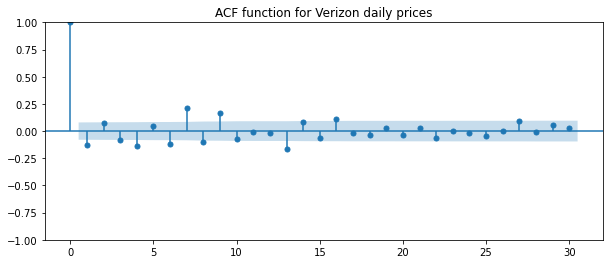

In [56]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(att_close_diff, lags=30, title='ACF function for AT&T differenced prices', ax=ax);

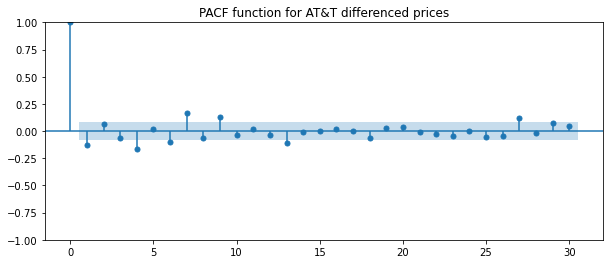

In [57]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(att_close_diff, lags=30, method='ywm', title='PACF function for AT&T differenced prices', ax=ax);

The difference prices is stationary but with ACF and PACF plotted, it appears to be white noice. As there is not visible auto correlation in this series.

### Verizon

In [60]:
test_stationarity(vz.close)

((-3.7263620206715724,
  0.0037572635909176176,
  9,
  598,
  {'1%': -3.4413325959192393,
   '5%': -2.86638530474078,
   '10%': -2.569350430308386},
  1169.0413368128811),
 True)

VZ prices are stationary, and does not need differencing.

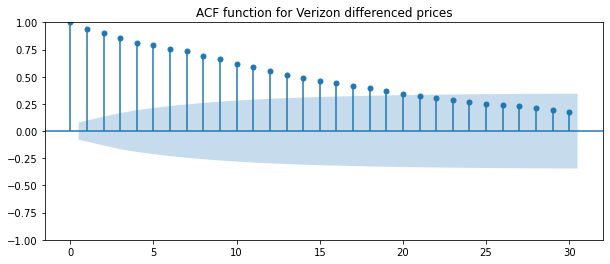

In [61]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(vz.close, lags=30, title='ACF function for Verizon prices', ax=ax);

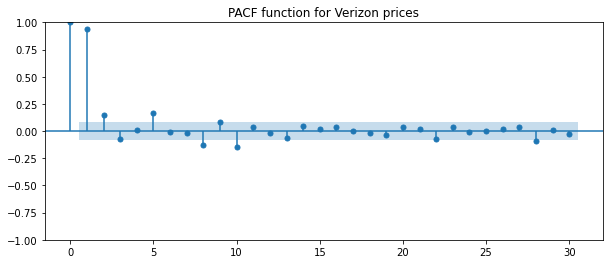

In [62]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(vz.close, lags=30, method='ywm', title='PACF function for Verizon prices', ax=ax);

The raw closing prices for Verizon is stationary.